# Импортируем все библиотеки

In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import re

import tensorflow as tf
from tensorflow.keras.layers import Dense, Bidirectional, Activation, Dropout, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Посмотрим на данные

In [34]:
train_df = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip',sep='\t')
test_df  = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip',sep='\t')
sub_df = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv')

In [35]:
train_df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [36]:
train_df['Sentiment']

0         1
1         2
2         2
3         2
4         2
         ..
156055    2
156056    1
156057    3
156058    2
156059    2
Name: Sentiment, Length: 156060, dtype: int64

In [37]:
data_labels = [
    'negative',
    'somewhat negative',
    'neutral',
    'somewhat positive',
    'positive'
]

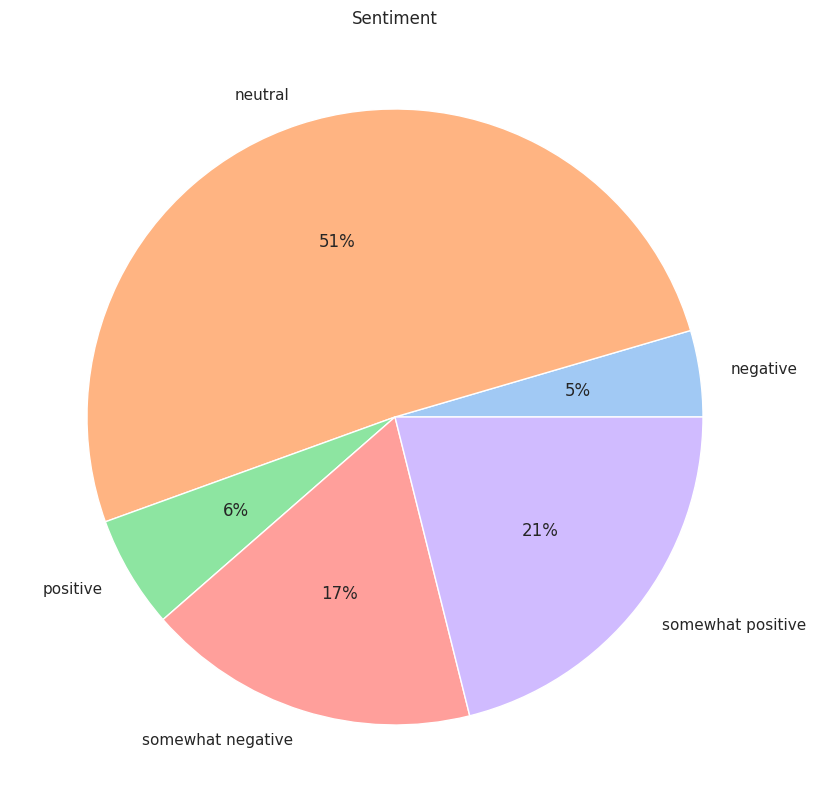

In [38]:
sns.set(rc={'figure.figsize': (10, 10)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(train_df['Sentiment'].map(str).replace('0', 'negative').replace('1', 'somewhat negative')
       .replace('2', 'neutral').replace('3', 'somewhat positive').replace('4', 'positive').unique())
dt = np.array([len(train_df[train_df['Sentiment'].map(str).replace('0', 'negative').replace('1', 'somewhat negative')
       .replace('2', 'neutral').replace('3', 'somewhat positive').replace('4', 'positive') == i]) for i in labels])
plt.pie(dt, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('Sentiment')
plt.show()

In [39]:
test_df

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [40]:
sub_df

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
...,...,...
66287,222348,2
66288,222349,2
66289,222350,2
66290,222351,2


# Проведём токенизацию и составим словарь

In [41]:
train_df['Phrase'].to_list()[:10]

['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
 'A series of escapades demonstrating the adage that what is good for the goose',
 'A series',
 'A',
 'series',
 'of escapades demonstrating the adage that what is good for the goose',
 'of',
 'escapades demonstrating the adage that what is good for the goose',
 'escapades',
 'demonstrating the adage that what is good for the goose']

In [42]:
texts = train_df['Phrase'].to_list()
print('max len symbols', max(map(lambda x: len(x), texts)))
print('max len text', max(map(lambda x: len(x.split()), texts)))
text_set = []
for i in texts:
    text_set.extend(i.split())
print('max count words', len(set(text_set)))

max len symbols 283
max len text 52
max count words 18226


In [43]:
maxWordsCount = 18226
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!–"—#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n\r«»', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(texts)

In [44]:
dist = list(tokenizer.word_counts.items())
print(dist[:10])
print(texts[0][:100])

[('a', 36415), ('series', 363), ('of', 32702), ('escapades', 5), ('demonstrating', 19), ('the', 51633), ('adage', 17), ('that', 12338), ('what', 1926), ('is', 13476)]
A series of escapades demonstrating the adage that what is good for the goose is also good for the g


In [45]:
max_text_len = 52
data = tokenizer.texts_to_sequences(texts)
data_pad = pad_sequences(data, maxlen=max_text_len)
print(data_pad)

[[   0    0    0 ...    3    2   42]
 [   0    0    0 ...   13    1 2976]
 [   0    0    0 ...    0    2  323]
 ...
 [   0    0    0 ...    0 9376 9377]
 [   0    0    0 ...    0    0 9376]
 [   0    0    0 ...    0    0 9377]]


In [46]:
print(list(tokenizer.word_index.items())[:100])
print()
print(len(list(tokenizer.word_index.items())))

[('the', 1), ('a', 2), ('of', 3), ('and', 4), ('to', 5), ("'s", 6), ('in', 7), ('is', 8), ('that', 9), ('it', 10), ('as', 11), ('with', 12), ('for', 13), ('its', 14), ('film', 15), ('an', 16), ('movie', 17), ('this', 18), ('but', 19), ('be', 20), ('on', 21), ('you', 22), ('by', 23), ("n't", 24), ('more', 25), ('his', 26), ('one', 27), ('about', 28), ('not', 29), ('at', 30), ('or', 31), ('than', 32), ('from', 33), ('all', 34), ('like', 35), ('have', 36), ('are', 37), ('has', 38), ("'", 39), ('so', 40), ('out', 41), ('story', 42), ('rrb', 43), ('up', 44), ('who', 45), ('good', 46), ('too', 47), ('most', 48), ('into', 49), ('lrb', 50), ('if', 51), ('what', 52), ('time', 53), ('their', 54), ('no', 55), ('characters', 56), ('much', 57), ("''", 58), ('comedy', 59), ('i', 60), ('your', 61), ('can', 62), ('just', 63), ('life', 64), ('some', 65), ('does', 66), ('even', 67), ('little', 68), ('funny', 69), ('will', 70), ('well', 71), ('way', 72), ('very', 73), ('been', 74), ('any', 75), ('make', 

# Разделим на тренировочную и валидационную выборки

In [47]:
X = np.array(data_pad)
Y = train_df['Sentiment']

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.1, random_state=42)

# Сделаем модель и обучим её

In [48]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [49]:
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Embedding(maxWordsCount, 128, input_length = max_text_len))
    # model.add(LSTM(128, dropout=0.8, recurrent_dropout=0.8, return_sequences=True))
    model.add(Bidirectional(LSTM(128, dropout=0.8, recurrent_dropout=0.8, return_sequences=True)))
    # model.add(Bidirectional(LSTM(256, dropout=0.6,recurrent_dropout=0.6, return_sequences=True)))
    model.add(Bidirectional(LSTM(128, dropout=0.5,recurrent_dropout=0.5, return_sequences=False)))
    # model.add(Bidirectional(LSTM(64, dropout=0.45,recurrent_dropout=0.45, return_sequences=False)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))

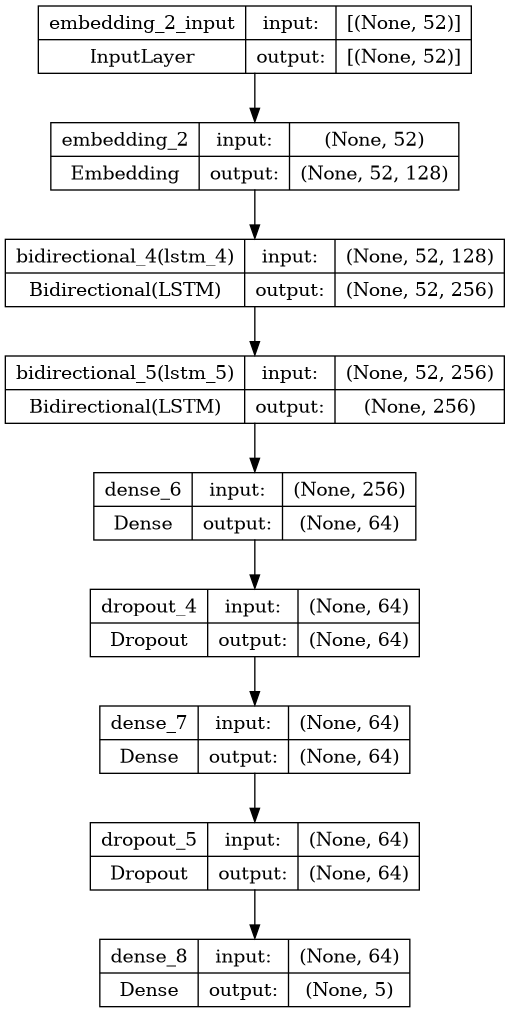

In [50]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 52, 128)           2332928   
                                                                 
 bidirectional_4 (Bidirecti  (None, 52, 256)           263168    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)               

In [52]:
from tensorflow.keras.optimizers import Adam

with tf.device('/GPU:0'):
    best_w = ModelCheckpoint(
        filepath='model_NLP.h5',
        verbose=1,
        save_best_only=True
    )

    opt = Adam(learning_rate=3e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=opt,
        metrics=['accuracy']
    )

In [53]:
with tf.device('/GPU:0'):
    H = model.fit(X_train, Y_train,
                  validation_data=(X_valid, Y_valid),
                  batch_size=512,
                  epochs=50,
                  shuffle=True,
                  callbacks=[best_w])

Epoch 1/50
275/275 [==============================] - ETA: 0s - loss: 1.2462 - accuracy: 0.5132
Epoch 1: val_loss improved from inf to 1.15662, saving model to model_NLP.h5
275/275 [==============================] - 229s 788ms/step - loss: 1.2462 - accuracy: 0.5132 - val_loss: 1.1566 - val_accuracy: 0.5208
Epoch 2/50


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


275/275 [==============================] - ETA: 0s - loss: 1.1330 - accuracy: 0.5441
Epoch 2: val_loss improved from 1.15662 to 1.09423, saving model to model_NLP.h5
275/275 [==============================] - 198s 721ms/step - loss: 1.1330 - accuracy: 0.5441 - val_loss: 1.0942 - val_accuracy: 0.5559
Epoch 3/50
275/275 [==============================] - ETA: 0s - loss: 1.0712 - accuracy: 0.5697
Epoch 3: val_loss improved from 1.09423 to 1.05109, saving model to model_NLP.h5
275/275 [==============================] - 194s 704ms/step - loss: 1.0712 - accuracy: 0.5697 - val_loss: 1.0511 - val_accuracy: 0.5780
Epoch 4/50
275/275 [==============================] - ETA: 0s - loss: 1.0163 - accuracy: 0.5938
Epoch 4: val_loss improved from 1.05109 to 0.96465, saving model to model_NLP.h5
275/275 [==============================] - 192s 698ms/step - loss: 1.0163 - accuracy: 0.5938 - val_loss: 0.9646 - val_accuracy: 0.6175
Epoch 5/50
275/275 [==============================] - ETA: 0s - loss: 0.931

Text(0.5, 1.0, 'Accuracy')

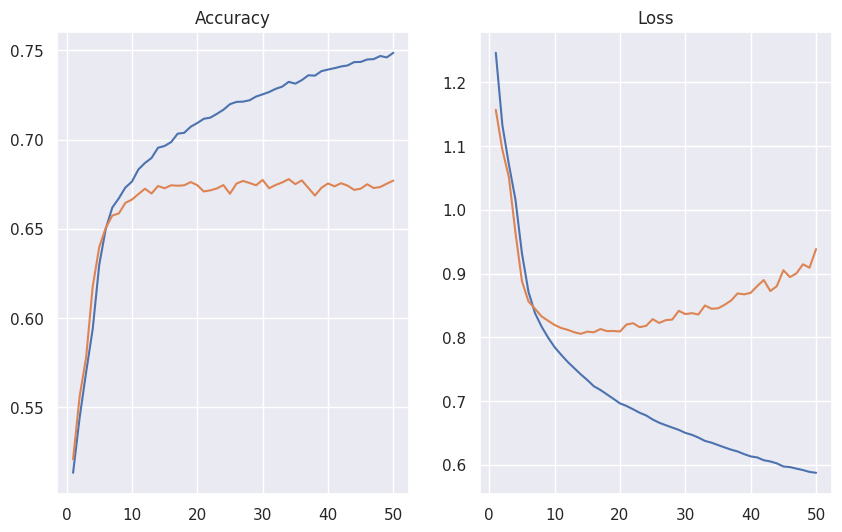

In [54]:
plt.figure(figsize=(10, 6))
# N = np.arange(0, EPOCHS)

acc = H.history["accuracy"]
val_acc = H.history['val_accuracy']

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(val_acc) + 1), H.history["loss"], label="train_loss")
plt.plot(np.arange(1, len(val_acc) + 1), H.history["val_loss"], label="vall_loss")
plt.title("Loss")

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(acc) + 1), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(1, len(acc) + 1), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")

## Подгрузим итоговую модель

In [55]:
model = tf.keras.models.load_model("/kaggle/working/model_NLP.h5")

In [87]:
Y_valid

95722     2
147312    4
36991     2
150211    2
140655    1
         ..
127863    4
2518      2
81342     2
72925     2
114760    2
Name: Sentiment, Length: 15606, dtype: int64

## Посмотрим на итоги модели

In [89]:
predictions = model.predict(X_valid, batch_size = 32)

488/488 [==============================] - 22s 44ms/step


In [101]:
print(classification_report(Y_valid.to_numpy(dtype=float),
                            predictions.argmax(axis=1),
                            target_names=data_labels))

                   precision    recall  f1-score   support

         negative       0.61      0.37      0.46       748
somewhat negative       0.55      0.61      0.58      2807
          neutral       0.76      0.80      0.78      7807
somewhat positive       0.60      0.59      0.59      3285
         positive       0.61      0.39      0.47       959

         accuracy                           0.67     15606
        macro avg       0.63      0.55      0.58     15606
     weighted avg       0.67      0.67      0.67     15606



# Обработаем тест и предскажем его

## Обработка

In [102]:
test_df

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [103]:
sub_df

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
...,...,...
66287,222348,2
66288,222349,2
66289,222350,2
66290,222351,2


In [104]:
X_test = test_df['Phrase'].map(lambda x: str(x).lower()).to_list()

In [105]:
X_test[:10]

['an intermittently pleasing but mostly routine effort .',
 'an intermittently pleasing but mostly routine effort',
 'an',
 'intermittently pleasing but mostly routine effort',
 'intermittently pleasing but mostly routine',
 'intermittently pleasing but',
 'intermittently pleasing',
 'intermittently',
 'pleasing',
 'but']

In [106]:
max_text_len = 52
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_text_len)

In [107]:
X_test

array([[   0,    0,    0, ...,  614, 1024,  392],
       [   0,    0,    0, ...,  614, 1024,  392],
       [   0,    0,    0, ...,    0,    0,   16],
       ...,
       [   0,    0,    0, ...,    2,  126, 5916],
       [   0,    0,    0, ...,    2,  126, 5916],
       [   0,    0,    0, ...,    0,  373, 2014]], dtype=int32)

## Предсказание

In [108]:
prediction = model.predict(X_test)

2072/2072 [==============================] - 93s 45ms/step


In [109]:
prediction

array([[5.6033727e-04, 3.2309696e-02, 4.1465142e-01, 5.3142089e-01,
        2.1057626e-02],
       [5.6033727e-04, 3.2309696e-02, 4.1465142e-01, 5.3142089e-01,
        2.1057626e-02],
       [3.3445927e-04, 4.5437645e-02, 7.9631293e-01, 1.5647575e-01,
        1.4392388e-03],
       ...,
       [3.3045020e-02, 4.5206386e-01, 4.6687081e-01, 4.6321575e-02,
        1.6988107e-03],
       [3.3045020e-02, 4.5206386e-01, 4.6687081e-01, 4.6321575e-02,
        1.6988107e-03],
       [1.2675108e-02, 5.0224656e-01, 4.6460104e-01, 2.0279696e-02,
        1.9759069e-04]], dtype=float32)

In [110]:
prediction = prediction.argmax(axis=1)

In [111]:
prediction

array([3, 3, 2, ..., 2, 2, 1])

## Отправка

In [112]:
sub_df['Sentiment'] = prediction

In [113]:
sub_df

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3
...,...,...
66287,222348,1
66288,222349,1
66289,222350,2
66290,222351,2


In [114]:
sub_df.to_csv('submit_nlp.csv', index=False)